In [31]:
import os
# setup pyspark jars
os.environ["PYSPARK_SUBMIT_ARGS"] = "--jars /home/cloudera/twitter_stream/libs/spark-core_2.11-1.5.2.logging.jar,/usr/lib/hbase/hbase-spark-1.2.0-cdh5.14.0.jar,/usr/lib/hive/lib/guava-14.0.1.jar,/usr/lib/hive/lib/hive-hbase-handler-1.1.0-cdh5.14.0.jar,/usr/lib/hbase/lib/htrace-core.jar,/usr/lib/zookeeper/zookeeper.jar,/usr/lib/hbase/hbase-client.jar,/usr/lib/hbase/hbase-common.jar,/usr/lib/hbase/hbase-protocol.jar,/usr/lib/hbase/hbase-server.jar,/usr/lib/hbase/hbase-hadoop-compat.jar,/usr/lib/hbase/hbase-hadoop2-compat.jar,/usr/lib/hbase/lib/metrics-core-2.2.0.jar pyspark-shell"

from __future__ import unicode_literals

from pyspark import SparkContext
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.rc('font', family='Arial')
import matplotlib.dates as mdates
from matplotlib.ticker import IndexFormatter
%matplotlib inline
#pd.__version__

# show col title
def show_col_title(p, data):
    for rect, total in zip(p.patches, data):
        p.text(rect.get_x() + rect.get_width() / 2, rect.get_height(), '{0:,}'.format(total), 
                    ha='center', va='bottom', fontsize=12, fontweight='bold')


sqlContext = SparkSession\
    .builder\
    .appName("Python Spark SQL Hive matplotlib") \
    .config("hive.metastore.uris", "thrift://127.0.0.1:9083") \
    .enableHiveSupport() \
    .getOrCreate()

In [32]:
# top 10 hashtags
df_hashtag = sqlContext.sql('SELECT hashtag AS hashtag, COUNT(*) AS total\
                        FROM default.tweets LATERAL VIEW explode(SPLIT(lower(general_hashtags),",")) aTable AS hashtag\
                        WHERE general_hashtags IS NOT NULL AND LENGTH(general_hashtags) > 0\
                        GROUP BY hashtag\
                        ORDER BY total DESC\
                        LIMIT 10').toPandas()

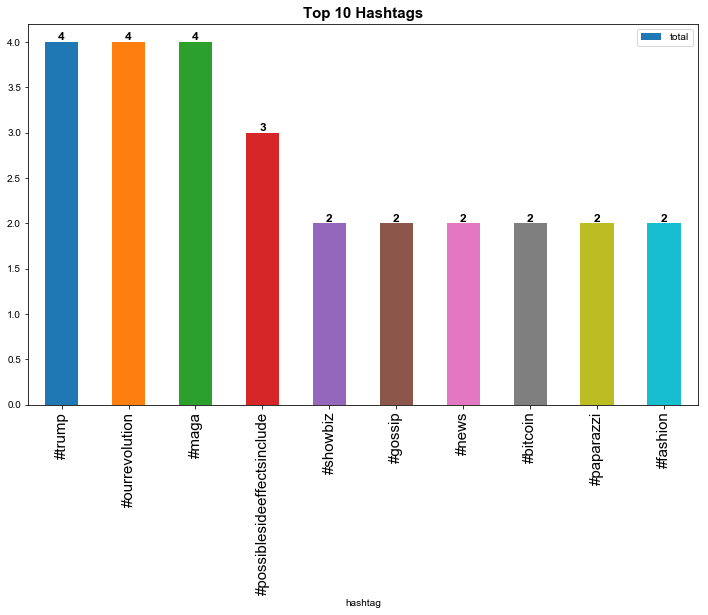

In [33]:
#print(df_hashtag)
fig1, ax1 = plt.subplots(figsize=(12,7))
ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='y', labelsize=10)
ax1.set_title('Top 10 Hashtags', fontsize=15, fontweight='bold')
chart1 = df_hashtag.plot(ax=ax1, kind='bar',x='hashtag', y='total')
show_col_title(chart1, df_hashtag['total'])
# save result to file
#plt.savefig('tweet_by_country', format='png')

In [34]:
# top 10 cities in US
#WHERE place_place_type = "city" AND place_country_code = "US"\
df_cities = sqlContext.sql('SELECT CONCAT(place_name," - ",place_country) AS name, COUNT(*) AS total\
                        FROM default.tweets\
                        GROUP BY place_name, place_country\
                        ORDER BY total DESC\
                        LIMIT 10').toPandas()
#print(df_cities)

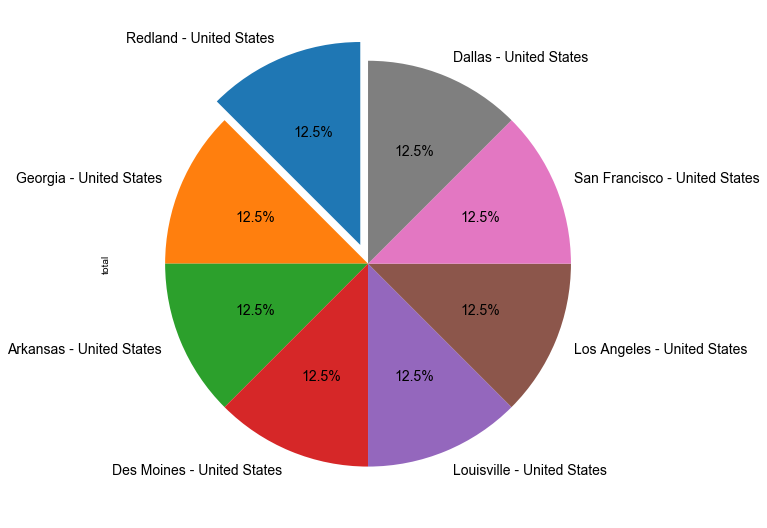

In [35]:
plt.figure(figsize=(20,10))
ax2 = plt.subplot(121, aspect='equal')

explode=[0] * len(df_cities)
#explode first one
explode[0] = 0.1

df_cities.plot(kind='pie', y = 'total', ax=ax2, autopct='%1.1f%%', explode=tuple(explode),
          startangle=90, shadow=False, labels=df_cities['name'], legend = False, fontsize=14)


In [36]:
# 
df_lang = sqlContext.sql('SELECT UPPER(general_lang) AS group, COUNT(*) AS total\
                        FROM default.tweets\
                        GROUP BY general_lang\
                        ORDER BY total DESC\
                        LIMIT 10').toPandas()

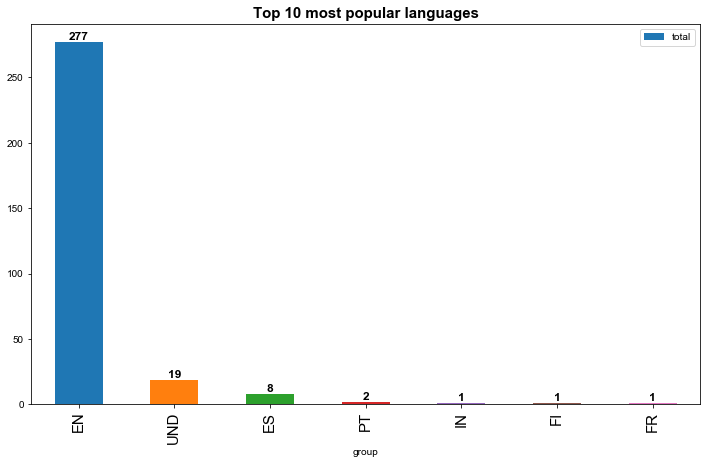

In [37]:
fig3, ax3 = plt.subplots(figsize=(12,7))
ax3.tick_params(axis='x', labelsize=15)
ax3.tick_params(axis='y', labelsize=10)
ax3.set_title('Top 10 most popular languages', fontsize=15, fontweight='bold')

chart3 = df_lang.plot(ax=ax3, kind='bar',x='group', y='total')
show_col_title(chart3, df_lang['total'])

#plt.savefig('tweet_by_country', format='png')

In [38]:
# total by hour - localtime CST time zone
df4 = sqlContext.sql('SELECT CONCAT(MONTH(local_created_ts), "/", DAY(local_created_ts), " ", HOUR(local_created_ts), "h") AS group, COUNT(*) total\
                    FROM (SELECT from_utc_timestamp(general_created_ts, "CST") AS local_created_ts \
                            FROM default.vw_tweets) AS tbl\
                    GROUP BY group\
                    ORDER BY group').toPandas()

df4.set_index('group',inplace=True)

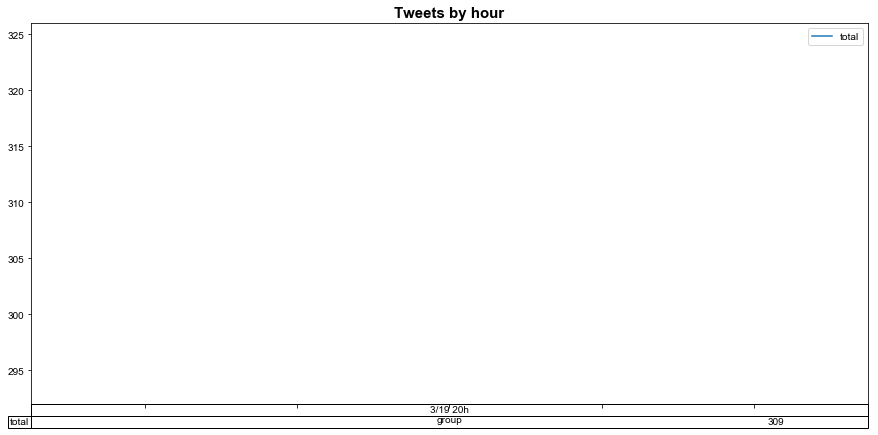

In [39]:
#print(df4)
fig, ax4 = plt.subplots(figsize=(15,7))
ax4.set_title("", fontsize=18, )
ax4.set_title('Tweets by hour', fontsize=15, fontweight='bold')
chart4 = df4.plot(ax=ax4, table=True)